Küme Dağılımı:
 cluster
-1     535
 4     233
 26    139
 3     118
 0      73
 25     26
 2      23
 11     10
 6       9
 21      9
 1       8
 15      7
 20      7
 23      7
 10      7
 13      7
 17      7
 18      7
 19      7
 7       6
 24      5
 22      5
 5       5
 16      5
 14      5
 9       5
 8       5
 12      5
Name: count, dtype: int64


C:\Users\uslan\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


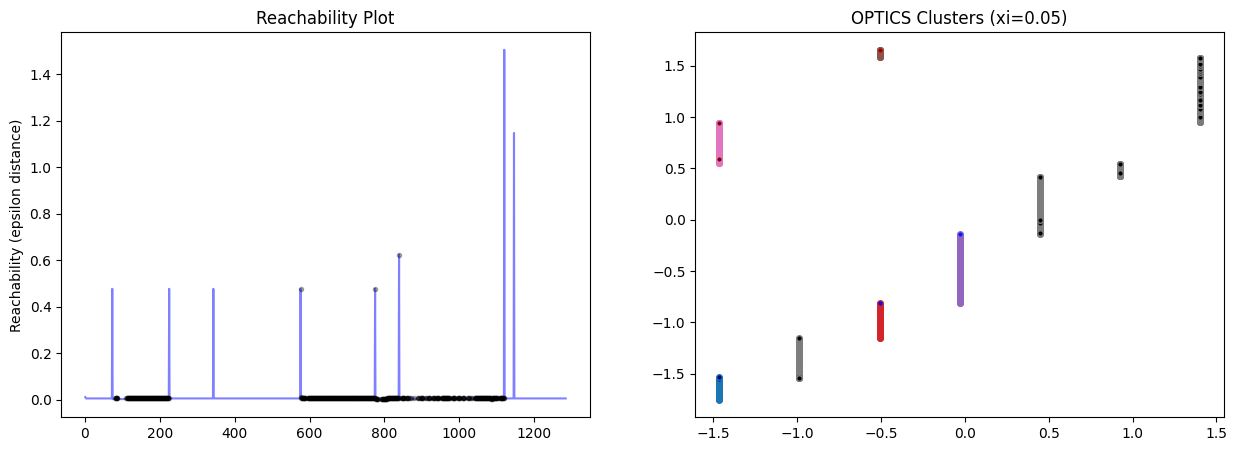

✅ Mean Shift benchmark verisi başarıyla eklendi.


In [ ]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS  # Scikit-learn'in OPTICS implementasyonu
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


# MeanShift sınıfının DIŞINA taşı!
def save_to_benchmark(X, labels, accuracy=None):
    sil_score = silhouette_score(X, labels)
    calinski_score = calinski_harabasz_score(X, labels)
    davies_score = davies_bouldin_score(X, labels)

    benchmark_entry = {
        "vectorizer": "TF-IDF",
        "cluster_model": "OPTICS",
        "accuracy": float(round(accuracy, 4)) if accuracy is not None else "N/A",
        "silhouette": float(round(sil_score, 4)),
        "calinski_harabasz": float(round(calinski_score, 4)),
        "davies_bouldin": float(round(davies_score, 4))
    }

    benchmark_path = "../../Outputs/benchmark.json"
    if os.path.exists(benchmark_path):
        with open(benchmark_path, "r", encoding="utf-8") as f:
            try:
                benchmark_data = json.load(f)
            except json.JSONDecodeError:
                benchmark_data = []
    else:
        benchmark_data = []

    benchmark_data.append(benchmark_entry)

    with open(benchmark_path, "w", encoding="utf-8") as f:
        json.dump(benchmark_data, f, indent=4, ensure_ascii=False)

    print(f"✅ Mean Shift benchmark verisi başarıyla eklendi.")


# 1. Veri Hazırlama
def prepare_data(filepath):
    df = pd.read_csv(filepath)

    # Kategorik verileri sayısallaştır
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        df[col] = pd.factorize(df[col])[0]  # Label Encoding alternatifi

    # Sayısal sütunları seç ve NaN'leri temizle
    numeric_df = df.select_dtypes(include=np.number).dropna()
    return numeric_df

# 2. OPTICS Kümeleme
def apply_optics(data, min_samples=5, xi=0.05):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)

    # OPTICS modeli
    clustering = OPTICS(min_samples=min_samples, xi=xi, metric='euclidean')
    clustering.fit(X_scaled)

    return clustering, X_scaled

# 3. Sonuçları Görselleştirme
def visualize_results(X, clustering):
    # Reachability plot
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    space = np.arange(len(X))
    reachability = clustering.reachability_[clustering.ordering_]
    plt.plot(space, reachability, 'b-', alpha=0.5)
    plt.plot(space[clustering.labels_[clustering.ordering_] == -1],
             reachability[clustering.labels_[clustering.ordering_] == -1],
             'k.', alpha=0.3)
    plt.ylabel('Reachability (epsilon distance)')
    plt.title('Reachability Plot')

    # Kümeleme sonuçları
    plt.subplot(122)
    for klass in set(clustering.labels_):
        if klass == -1:
            color = 'k'  # Gürültü
        else:
            color = plt.cm.jet(float(klass) / np.max(clustering.labels_))

        Xk = X[clustering.labels_ == klass]
        plt.plot(Xk[:, 0], Xk[:, 1], 'o', markerfacecolor=color, markersize=4)

    plt.title(f'OPTICS Clusters (xi={clustering.xi:.2f})')
    plt.show()

# 4. Ana İşlem
def main():
    # Veriyi yükle
    data = prepare_data('../../Datas/data.csv')  # CSV dosya yolunu güncelleyin

    # OPTICS parametreleri
    min_samples = 5  # Minimum komşu sayısı
    xi = 0.05        # Küme eşik değeri (0-1 arası)

    # Kümeleme yap
    clustering, X_scaled = apply_optics(data, min_samples, xi)

    # Sonuçları DataFrame'e ekle
    data['cluster'] = clustering.labels_
    print("Küme Dağılımı:\n", data['cluster'].value_counts())

    # Görselleştirme
    visualize_results(X_scaled, clustering)
    save_to_benchmark(X_scaled, clustering.labels_, accuracy=None)

if __name__ == "__main__":
    main()